### Inversion of an Hermitian Matrix

Author: Andrés Gómez - 2020



The objective of this notebook is to solve the linear system

$$M\vec{x}=\vec{b}$$

where $M \in \mathbb{C}^{2^n\times2^n}$ is an hermitian Matrix with eigenvalues $\{\lambda_j, j=1\dots 2^n\}$, and $\vec{x}$ and $\vec{b} \in \mathbb{C}^{2^n}$

The original algorithm was proposed by [Aram W. Harrow, Avinatan Hassidim, and Seth Lloyd](https://arxiv.org/abs/0811.3171), but later was improved and a simpler version is described on [Danial Dervovic, Mark Herbster, Peter Mountney, Simone Severini, Naïri Usher, Leonard Wossnig](https://arxiv.org/abs/1802.08227), which is used on this notebook. 

The algorithm assumes that $\vec{b}$ is normalized, so it can be decomposed on the basis of a quantum system as

$$\vec{b}=\sum_{j=1}^{M}\beta_j|u_j\rangle$$

If $C \in \mathbb{R}$ is a constant such as $C<min\{\lambda_j\}$, being $\{\lambda_j\}$ the set of eigenvalues of $A$. In this case, the algorithm will find an approximation of $\vec{x}$ as

$$|x\rangle \approx C \sum_{j=1}^M \frac{\beta_j}{\lambda_j}|u_j\rangle$$

The algorithm uses three registers:

1. C or clock register, where the eigenvalues of the matrix $M$ are stored, with the number of qubits desired for the accuracy.
2. I to store $\vec{b}$
3. One ancilla qubit to calculate the inversion of the eigenvalues

For this notebook, the QuantumRegister is defined as:

$$|ancilla\rangle \otimes |Clock\rangle \otimes |b\rangle$$

The algorithm has 3 steps:

1. Calculate on register C the eigenvalues of $M$ using the Quantum Phase Estimation algorithm. Because $\vec{b}$ is a superposition of the eigenvectors, all the eigenvalues will be stored on this register because the parallelism of the Quantum Operators
2. Inverse the eigenvalues using controlled $R_y$ rotations over the ancilla qubit
3. Apply the inverse of step 1

Let's do it step by step.

**NOTE**. This version of the algorithm can work only for Hermitian matrices with eigenvalues $0<\lambda<=2^{accuracy}$



In [1]:
import projectq
from projectq.cengines import MainEngine
from projectq.ops import H,X,Ry,Rx,C,Measure,QFT,get_inverse,All,Swap,QubitOperator,TimeEvolution
from projectq.meta import Control,Compute,Uncompute
import numpy as np
import math
#import cmath


Auxiliary functions to show the matrix and quantum states

In [2]:
def MatrixToLatex(A):
    a="\\begin{pmatrix}"
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            if ((j+1)%A.shape[1])==0:
                a=a+"{0:.2f}".format(A[i,j])
            else:
                a=a+"%s&"%"{0:.2f}".format(A[i,j])
        if ((i+1)%A.shape[0])!=0:
            a=a+"\\\\"
    a=a+"\\end{pmatrix}"
    return(a)
def Display(string):
    from IPython.display import display, Markdown
    display(Markdown(string))
    
def get_state_as_str(eng,qubits,cheat=False):
    import numpy as np
    s="$"
    if (cheat):
        print("Cheat: ", eng.backend.cheat())
    
    for j in range(2**(len(qubits))):
        bits=np.binary_repr(j,width=len(qubits))
        a=eng.backend.get_amplitude("%s"%(bits[-1::-1]),qubits)
        if (abs(a.real)>0.0000001)|(abs(a.imag)>0.0000001):
            #print("Añado")
            if s!="$":
                s=s+"+"
            a="({:.5f})".format(a)
            s=s+"%s|%s\\rangle_a|%s\\rangle_C|%s\\rangle_b"%(a,bits[0],bits[1:-2],bits[-2:])
        #print(s)
    s=s+"$"
    #Display(s)
    return(s)

## <span style="color:blue"> 1. Create the matrix M</span>

Create one matrix $M$ from an spectral decomposition. Let be the eigenvectors

$$v_1=\frac{1 }{\sqrt{2}}(|00\rangle+|01\rangle)\\ v_2=\frac{1 }{\sqrt{2}}(|00\rangle-|01\rangle) \\v_3=\frac{1 }{\sqrt{2}}(|10\rangle+|11\rangle) \\ v_4=\frac{1 }{\sqrt{2}}(|10\rangle-|11\rangle)$$

and the eigenvalues $\lambda_1=16,\lambda_2=8,\lambda_3=4,\lambda_4=2$ 

Define the matrix
$$M=\lambda_1|v_1\rangle\langle v_1| +  \lambda_2|v_2\rangle\langle v_2| + \lambda_3|v_3\rangle\langle v_3| + \lambda_4|v_4 \rangle\langle v_4|$$


In [3]:
Lambda=[16,8,4,2]
Chi1P=(1/math.sqrt(2))*np.array([[1],[1],[0],[0]])
Chi1M=(1/math.sqrt(2))*np.array([[1],[-1],[0],[0]])
Chi2P=(1/math.sqrt(2))*np.array([[0],[0],[1],[1]])
Chi2M=(1/math.sqrt(2))*np.array([[0],[0],[1],[-1]])
Vector=[Chi1P,Chi1M,Chi2P,Chi2M] # Two, Three]
M=np.zeros((len(Chi1P),len(Chi1P)))
for i in range(len(Vector)):
    M=M+Lambda[i]*np.dot(Vector[i],Vector[i].T)
Display("M=%s"%MatrixToLatex(M))
    


M=\begin{pmatrix}12.00&4.00&0.00&0.00\\4.00&12.00&0.00&0.00\\0.00&0.00&3.00&1.00\\0.00&0.00&1.00&3.00\end{pmatrix}

Check that this matrix has the expected eigenvalues and eigenvector

In [4]:
E,v=np.linalg.eig(M)
Display("Eigenvalues: %s"%np.array2string(E,separator=", "))
Display("Eigenvectors: %s"%np.array2string(v,separator=", "))
for i in range(len(Vector)):
    Display("M|v_%d> = %s must be Lambda[%d]*|v[%d]>=%s"%(i,np.array2string(np.dot(M,Vector[i]).T), i,i,np.array2string(Lambda[i]*Vector[i].T,separator=", ")))


Eigenvalues: [16.,  8.,  4.,  2.]

Eigenvectors: [[ 0.70710678, -0.70710678,  0.        ,  0.        ],
 [ 0.70710678,  0.70710678,  0.        ,  0.        ],
 [ 0.        ,  0.        ,  0.70710678, -0.70710678],
 [ 0.        ,  0.        ,  0.70710678,  0.70710678]]

M|v_0> = [[11.3137085 11.3137085  0.         0.       ]] must be Lambda[0]*|v[0]>=[[11.3137085, 11.3137085,  0.       ,  0.       ]]

M|v_1> = [[ 5.65685425 -5.65685425  0.          0.        ]] must be Lambda[1]*|v[1]>=[[ 5.65685425, -5.65685425,  0.        ,  0.        ]]

M|v_2> = [[0.         0.         2.82842712 2.82842712]] must be Lambda[2]*|v[2]>=[[0.        , 0.        , 2.82842712, 2.82842712]]

M|v_3> = [[ 0.          0.          1.41421356 -1.41421356]] must be Lambda[3]*|v[3]>=[[ 0.        ,  0.        ,  1.41421356, -1.41421356]]

### Unitary operator from the Hermitian Matrix

From the Hermitian matrix $M \in \mathbb{C}^{2^n\times2^n}$, it is possible to create an Unitary Operator $U_M=e^{iM}$ with eigenvalues $e^{i\lambda_i}$, being $\lambda_i$ the eigenvalues of $M$ and with the same eigenvectors

Check that $U_M |v_i>=e^{iM}|v_i>=e^{i\lambda_i} |v_i>$

In [5]:
from scipy.linalg import expm
for i in range(len(Vector)):
    OP=np.dot(expm(1j*M),Vector[i])
    EIG=np.exp(1j*Lambda[i])*Vector[i]          
    Display("$$ U_M |v[%d]\\rangle=%s,e^{i\lambda_%d}|v[%d]\\rangle=%s$$"%(i,MatrixToLatex(OP),i,i,MatrixToLatex(EIG)))


$$ U_M |v[0]\rangle=\begin{pmatrix}-0.68-0.20j\\-0.68-0.20j\\0.00+0.00j\\0.00+0.00j\end{pmatrix},e^{i\lambda_0}|v[0]\rangle=\begin{pmatrix}-0.68-0.20j\\-0.68-0.20j\\0.00-0.00j\\0.00-0.00j\end{pmatrix}$$

$$ U_M |v[1]\rangle=\begin{pmatrix}-0.10+0.70j\\0.10-0.70j\\0.00+0.00j\\0.00+0.00j\end{pmatrix},e^{i\lambda_1}|v[1]\rangle=\begin{pmatrix}-0.10+0.70j\\0.10-0.70j\\-0.00+0.00j\\-0.00+0.00j\end{pmatrix}$$

$$ U_M |v[2]\rangle=\begin{pmatrix}0.00+0.00j\\0.00+0.00j\\-0.46-0.54j\\-0.46-0.54j\end{pmatrix},e^{i\lambda_2}|v[2]\rangle=\begin{pmatrix}0.00-0.00j\\0.00-0.00j\\-0.46-0.54j\\-0.46-0.54j\end{pmatrix}$$

$$ U_M |v[3]\rangle=\begin{pmatrix}0.00+0.00j\\0.00+0.00j\\-0.29+0.64j\\0.29-0.64j\end{pmatrix},e^{i\lambda_3}|v[3]\rangle=\begin{pmatrix}-0.00+0.00j\\-0.00+0.00j\\-0.29+0.64j\\0.29-0.64j\end{pmatrix}$$

Because the eigenvalues of this case are integers, they have an exact binary representation

In [6]:
for i in range(len(Lambda)):
    print("Binary of %.0f is "%(Lambda[i]),"{0:05b}".format(int(Lambda[i])))

Binary of 16 is  10000
Binary of 8 is  01000
Binary of 4 is  00100
Binary of 2 is  00010


### Matrix decomposition
Any matrix $M \in \mathbb{C}^{2^n}\times\mathbb{C}^{2^n}$, being $n$ the number of qubits, can be decomposed on tensor products of the extended Pauli set $\Sigma=\{I,X,Y,Z\}$. 

If  $\sigma_i \in \Sigma, i=1,2,3,4$,  then 

$$M=\sum_{ijk\dots l=1}^4 A_{ijk\dots l} \sigma_i\otimes\sigma_j\otimes\sigma_k\otimes \dots \otimes\sigma_l$$

where
$$A_{ijk\dots l}=\frac{1}{2^n}Tr[\sigma_i\otimes\sigma_j\otimes\sigma_k\otimes \dots \otimes\sigma_l M]$$

If the matrix M is Hermitian, $A_{ijk\dots l} \in \mathbb{R}$ 

The next function, **DecompositionOnSigmas**, makes this decomposition, creating a **[QubitOperator](https://projectq.readthedocs.io/en/latest/projectq.ops.html#projectq.ops.QubitOperator)** with this decomposition

In [7]:
def ProductTensor(A):
    a=A[-1]
    for i in range(len(A)-2,-1,-1):
        a=np.tensordot(A[i],a,axes=0)
        a=np.concatenate((np.concatenate((a[0][0],a[0][1]),axis=1),np.concatenate((a[1][0],a[1][1]),axis=1)))
    return a
def DecompositionOnSigmas(A):
    I=np.array([[1,0],[0,1]])
    X=np.array([[0,1],[1,0]])
    Y=np.array([[0,-1j],[1j,0]])
    Z=np.array([[1,0],[0,-1]])
    Pauli={"I":I,"X":X,"Y":Y,"Z":Z}
    import itertools
    n=int(math.log2(A.shape[0]))
    Ham=QubitOperator()
    for i in itertools.product("IXYZ",repeat=n):
        AxB=ProductTensor([Pauli[i[0]],Pauli[i[1]]])
        coef=(1/2**n)*complex(np.trace(np.dot(AxB,A)))
        if (coef.real!=0) | (coef.imag!=0):
            Paulis=""
            if i[0][0]!="I":
                Paulis=Paulis+"%s1"%i[0]
            if i[1][0]!="I":
                Paulis=Paulis+" %s0"%i[1]
            Ham=Ham+QubitOperator(Paulis,coef)
    return Ham

The decomposition of $M$ is

$$M=a_{11}(I\otimes I)+ a_{12}(I\otimes X) +a_{13}(I\otimes Y)+ a_{14}(I\otimes Z)\\+a_{21}(X\otimes I)+a_{22}(X\otimes X)+a_{23}(X\otimes Y)+a_{24}(X\otimes Z)\\+a_{31}(Y\otimes I)+a_{32}(Y\otimes X)+a_{33}(Y\otimes Y)+a_{34}(Y\otimes Z)\\+a_{41}(Z\otimes I)+a_{42}(Z\otimes X)+a_{43}(Z\otimes Y)+a_{44}(Z\otimes Z)$$ 


$$M= 7.5(I\otimes I) + 2.5(I\otimes X) + 4.5(Z\otimes I) +1.5(Z\otimes X)$$ 

For example:

$$a_{11}=\frac{1}{2^2}Tr((I\otimes I)M)=\frac{1}{4}Tr\left[ \begin{pmatrix}1&0&0&0\\0&1&0&0\\0&0&1&0\\0&0&0&1\end{pmatrix}\begin{pmatrix}12&4&0&0\\4&12&0&0\\0&0&3&1\\0&0&1&3\end{pmatrix}\right]=\\
=\frac{1}{4}Tr\left[\begin{pmatrix}12&0&0&0\\0&12&0&0\\0&0&3&0\\0&0&0&3\end{pmatrix} \right]=\frac{1}{4}30=7.5$$



In [8]:
DecompositionOnSigmas(M)

(1.4999999999999996+0j) X0 Z1 +
(7.499999999999998+0j) I +
(2.4999999999999996+0j) X0 +
(4.499999999999998+0j) Z1

## <span style="color:blue"> 2. First step: Calculate eigenvalues using Quantum Phase Estimation algorithm </span>

Now, construct the circuit for the phase estimation circuits. We will build in this case the unitary operator using the **[TimeEvolution](https://projectq.readthedocs.io/en/latest/projectq.ops.html#projectq.ops.TimeEvolution)** function of Project Q. This gate makes the time evolution of a Hamiltonian (in our case, the decomposition on $\sigma_i$ of M) as $$U_M=e^{-iMt}$$ 
We will choose $$t=\frac{-2\pi}{2^{accuracy}}$$, being *accuracy* the number of desired binary digits for our eigenvalues. 

This will map the eigenvalues of the Matrix M on the states of the qubit register. Because the $-$ sign is implicit in TimeEvolution operator and the positive exponent is desired to calculate the eigenvalues ( $e^{iMt}$ ), a $-$ sign must be included on the selected time. 

**CalculateEigenvalues** accepts as argument a number of a vector. From 0 to 3, this number will initialize the vector $b$ with the eigenvectors of M. From 4 and 6, b is initialized to:

$4, |b_4\rangle=|01\rangle=\frac{\sqrt{2}}{2}(|v_1\rangle - |v_2\rangle)=\beta_1|v_1\rangle + \beta_2 |v_2\rangle$

$5, |b_5\rangle=|10\rangle=\frac{\sqrt{2}}{2}(|v_3\rangle + |v_4\rangle)$

$6, |b_6\rangle=H_1 R_{x0}(0.05)R_{x1}(0.25)|00\rangle$

Let's see what's happen with these vectors and why we have selected this evolution time.

The controled operation $CU_M$ with a single additional qubit of the unitary gate $U_M$ is defined as:

$$CU_M=|0\rangle\langle0|\otimes I +|1\rangle\langle1|\otimes U_M$$

so,

$$CU_M(H|0\rangle\otimes|b_4\rangle)=CU_M[(\frac{1}{\sqrt{2}}(|0\rangle + |1\rangle)\otimes|b_4\rangle)]=$$
$$=\frac{1}{\sqrt{2}}[|0\rangle\otimes|b_4\rangle + |1\rangle\otimes U_M(|b_4\rangle)]=$$
$$=\frac{1}{\sqrt{2}}[|0\rangle\otimes (\beta_1 |v_1\rangle + \beta_2 |v_2\rangle) + |1\rangle\otimes U_M(\beta_1 |v_1\rangle + \beta_2 |v_2\rangle)]$$
$$= \frac{1}{\sqrt{2}}[|0\rangle \otimes(\beta_1 |v_1\rangle + \beta_2 |v_2\rangle)+ |1\rangle\otimes(\beta_1 e^{i\lambda_1t}|v_1\rangle + \beta_2 e^{i\lambda_2t}|v_2\rangle)]$$

$$=\frac{\beta_1}{\sqrt{2}}[|0\rangle \otimes |v_1\rangle + e^{i\lambda_1t}|1\rangle \otimes |v_1\rangle)]
+ \frac{\beta_2}{\sqrt{2}}[|0\rangle \otimes |v_2\rangle + e^{i\lambda_2t}|1\rangle \otimes |v_2\rangle)]$$
$$=\frac{1}{\sqrt{2}}[(|0\rangle + e^{i\lambda_1t}|1\rangle) \otimes \beta_1|v_1\rangle)]
+ \frac{1}{\sqrt{2}}[(|0\rangle + e^{i\lambda_2t}|1\rangle) \otimes \beta_2|v_2\rangle)]$$

Passing the eigenvalues to the control qubit and keeping the superposition of $|v_1\rangle$ and $|v_2\rangle$ on register $|b\rangle$

Defining the controlled unitary operation of operator U with qubit l as $C^lU$, if we appy $\Pi_{l=0}^{accuracy}C^l(U_M)^l$ on state $H^{\otimes accuracy}|0\rangle \otimes |b_4\rangle$, the result is:

$$\Pi_{l=0}^{accuracy}C^l(U_M)^l[H^{\otimes accuracy}|0\rangle \otimes |b_4\rangle] = [ \frac{\beta_1}{2^{accuracy/2}}\sum_{k=0}^{2^{accuracy}-1} e^{i\lambda_1 tk}|k\rangle \otimes |v_1\rangle ]+ [\frac{\beta_2}{2^{accuracy/2}}\sum_{k=0}^{2^{accuracy}-1} e^{i\lambda_2 tk}|k\rangle \otimes |v_2\rangle]$$

Choosing $t=\frac{2\pi}{2^{accuracy}}$, the final state after the controlled operations is:

$$[ \frac{\beta_1}{2^{accuracy/2}}\sum_{k=0}^{2^{accuracy}-1} e^{i2\pi k \frac{\lambda_1}{2^{accuracy}}}|k\rangle \otimes |v_1\rangle ]+ [\frac{\beta_2}{2^{accuracy/2}}\sum_{k=0}^{2^{accuracy}-1} e^{i2\pi k \frac{\lambda_2}{2^{accuracy}}}|k\rangle \otimes |v_2\rangle]$$

Now, applying now the inverse Quantum Fourier Transform on the control qubits:

$$(iQFT\otimes I)([ \frac{\beta_1}{2^{accuracy/2}}\sum_{k=0}^{2^{accuracy}-1} e^{i2\pi k \frac{\lambda_1}{2^{accuracy}}}|k\rangle \otimes |v_1\rangle ]+ [\frac{\beta_2}{2^{accuracy/2}}\sum_{k=0}^{2^{accuracy}-1} e^{i2\pi k \frac{\lambda_2}{2^{accuracy}}}|k\rangle \otimes |v_2\rangle])=$$

$$=iQFT( \frac{\beta_1}{2^{accuracy/2}}\sum_{k=0}^{2^{accuracy}-1} e^{i2\pi k \frac{\lambda_1}{2^{accuracy}}}|k\rangle) \otimes I|v_1\rangle+
iQFT( \frac{\beta_2}{2^{accuracy/2}}\sum_{k=0}^{2^{accuracy}-1} e^{i2\pi k \frac{\lambda_2}{2^{accuracy}}}|k\rangle) \otimes I|v_2\rangle 
=$$
$$=\beta_1|\lambda_1\rangle\otimes|v_1\rangle + \beta_2|\lambda_2\rangle\otimes|v_2\rangle
$$

As consecuence, the state has a superposition of all the eigenvalues of $M$ on the control register.

### Operations to init the state to the values of different vectors

In [9]:
def InitState(b,vector=0,eng=None,cheat=False):
    """
    Init the vector b
    """
    if vector==0:
        """
        1/sqrt(2)(|00>+|01>)
        """
        H|b[0]
    if vector==1:
        """
        1/sqrt(2)(|00>-|01>)
        """
        X|b[0]
        H|b[0]
    if vector==2:
        """
        1/sqrt(2)(|10>+|11>)
        """

        X|b[1]
        H|b[0]
    if vector==3:
        """
        1/sqrt(2)(|10>-|11>)
        """
        X|b[1]
        X|b[0]
        H|b[0]
    if vector==4:
        """
        |01>
        """
        X|b[0]
    if vector==5:
        """
        |10>
        """
        X|b[1]
        
    if vector==6:
        Rx(0.05)|b[0]
        Rx(0.25)|b[1]
        H|b[1]

    if (eng!=None) & cheat:
        eng.flush()
        Display(get_state_as_str(eng,b+Clock))
    return


### Quantum Phase Estimation algorithm for an Hermitian Matrix

In [10]:
def QPE(M,Clock,b,eng=None,cheat=True):
    Ham=DecompositionOnSigmas(M)
    
    accuracy=len(Clock)
    t0=2*math.pi/2**accuracy
    """
    Init the Clock
    """
    
    All(H)|Clock
    
    """
    Apply the time evolution of the Hamiltonian
    """
    for i in range(len(Clock)):
        with Control(eng,Clock[i]):
            TimeEvolution(time=-t0*2**i,hamiltonian=Ham)|b
    
    """
    Apply the iQFT
    """
    for i in range(len(Clock)//2):
        Swap | (Clock[i],Clock[len(Clock)-i-1])
    get_inverse(QFT)|Clock
    #H|C
    
    if (eng==None) & cheat:
        eng.flush()
        Display(get_state_as_str(eng,b+Clock))


### Main function to calculate the eigenvalues of an Hermitian Matrix

In [11]:
def CalculateEigenvalues(M,accuracy,vector=0,cheat=False):
    eng=MainEngine()
    cols = M.shape[0]
    m = int(math.log2(cols))
    Clock = eng.allocate_qureg(accuracy)
    b = eng.allocate_qureg(m)
    
    InitState(b,vector=vector,eng=eng,cheat=cheat)
    
    QPE(M,Clock,b,eng,cheat)
    
    """
    Measure the registers
    """
    All(Measure)|Clock
    All(Measure)|b
    eng.flush()

    """
    Get output 
    """
    output=[int(q) for q in Clock]
    ancilla=[int(q) for q in b]

    del Clock
    del b
    del eng

    """
    Calculate the Eigenvalue
    """
    bits=0
    for (k,i) in enumerate(output):
        bits=bits+i*2.**k
    return bits


We will calculate the fase with an accuracy of $$\frac{1}{2^5}$$

Because this is a probabilistic algorithm, we have to repeat the experiment several times. In this case, 100

Calculate the eigenvalues for the eigenvectors

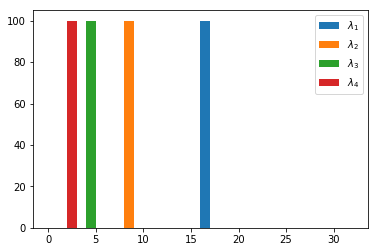

In [12]:
accuracy=5
experiments=100
%matplotlib inline
import matplotlib.pyplot as plt
for j in range(0,4,1):
    out=[]
    for i in range(experiments):
        out.append(CalculateEigenvalues(M,accuracy=accuracy,vector=j,cheat=False))
    x=plt.hist(out,bins=2**accuracy,range=(0,(2**accuracy)),label="$\lambda_%d$"%(j+1))
plt.legend()
plt.show()
plt.close()


Choosing vector=4, 

$|b_4\rangle=|01\rangle=\frac{\sqrt{2}}{2}(|v_1\rangle-|v_2\rangle)$

this is a superposition of the eigenvectors $|v_1\rangle$ and $|v_2\rangle$, so the final state after the QPE must contain eigenvalues $\lambda_1$ and $\lambda_2$

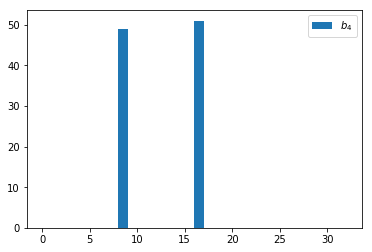

In [13]:
out=[]
j=4
for i in range(experiments):
    out.append(CalculateEigenvalues(M,accuracy=accuracy,vector=j,cheat=False))
x=plt.hist(out,bins=2**accuracy,range=(0,(2**accuracy)),label="$b_%d$"%j)
plt.legend()
plt.show()
plt.close()

For the vector=5, 

$|b_5\rangle=|10\rangle=\frac{\sqrt{2}}{2}(|v_3\rangle-|v_4\rangle)$

so, because this superposition, the final state after the QPE must contain eigenvalues $\lambda_3$ and $\lambda_4$

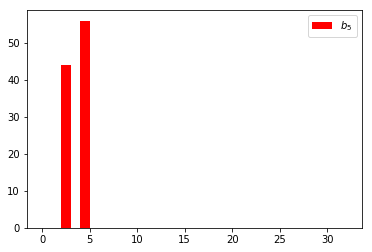

In [14]:
out=[]
j=5
for i in range(experiments):
    out.append(CalculateEigenvalues(M,accuracy=accuracy,vector=j,cheat=False))
x=plt.hist(out,bins=2**accuracy,range=(0,(2**accuracy)),color="r",label="$b_%d$"%j)
plt.legend()
plt.show()
plt.close()

And, because 
$$|b_6\rangle=H_1 R_{x0}(0.05)R_{x1}(0.25)|00\rangle = \sum_{i=1}^4\beta_i |v_i\rangle$$

the final state must have a combination of all eigenvalues

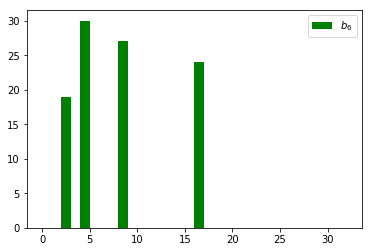

In [15]:
out=[]
j=6
for i in range(experiments):
    out.append(CalculateEigenvalues(M,accuracy=accuracy,vector=j,cheat=False))
x=plt.hist(out,bins=2**accuracy,range=(0,(2**accuracy)),color="g",label="$b_%d$"%j)
plt.legend()
plt.show()
plt.close()

## <span style="color:blue"> 3. Second step: Inversion of eigenvalues </span>

After the previous step, the register Clock will have a superposition of all eigenvalues as states. On the next step, the values of these states will be inverted on the amplitudes, using an ancilla qubit over a set of controlled $R_y$ operations will be applyed.


Following the definition of the QuantumRegister

$$|ancilla\rangle \otimes |Clock\rangle \otimes |b\rangle$$

, let assume that the ancilla and Clock registers are ordered such than one Quantum State is defined by

$$|a_0 c_{n-1} c_{n-2} \dots c_0\rangle=|a_0\rangle \otimes |c_{n-1} c_{n-2} \dots c_0\rangle_C $$

being $n$ the accuracy and number of qubits on the Clock register.



In [16]:
from sympy import *
from sympy.physics.quantum import TensorProduct
c=Symbol("C")
#Alpha=Symbol("beta_1")
#Beta=Symbol("beta_2")
Theta=Symbol("Theta")
SRy=Matrix([[cos(Theta/2),-sin(Theta/2)],[sin(Theta/2),cos(Theta/2)]])
Uno=Matrix([[0],[1]])
Zero=Matrix([[1],[0]])
#B=TensorProduct(Uno.T,Uno)
#A=TensorProduct(Zero.T,Zero)
#X_matrix=Matrix([[0,1],[1,0]])
I=Matrix([[1,0],[0,1]])
II=I.copy()

In this case, the control $R_y$ unitary operator by state $|c_i\rangle$ on ancilla $|a_0\rangle$ is defined as:

$$C_{c_i}R_y(\theta)= R_y(\theta)\otimes |c_i\rangle\langle c_i|+I\otimes (I-|c_i\rangle\langle c_i|)$$

For state $|10\rangle$ as control, is

In [17]:
CRy=SRy.copy()
OneZero=Matrix(np.array([[0],[0],[1],[0]]))
COneZero=TensorProduct(OneZero,OneZero.T)
II=I.copy()
for i in range(1):
    II=TensorProduct(I,II)
CRy=TensorProduct(CRy,COneZero)+TensorProduct(I,(II-COneZero))
CRy

Matrix([
[1, 0,            0, 0, 0, 0,             0, 0],
[0, 1,            0, 0, 0, 0,             0, 0],
[0, 0, cos(Theta/2), 0, 0, 0, -sin(Theta/2), 0],
[0, 0,            0, 1, 0, 0,             0, 0],
[0, 0,            0, 0, 1, 0,             0, 0],
[0, 0,            0, 0, 0, 1,             0, 0],
[0, 0, sin(Theta/2), 0, 0, 0,  cos(Theta/2), 0],
[0, 0,            0, 0, 0, 0,             0, 1]])

The angle of rotation will be

$$\theta=2*sin^{-1}(\frac{C}{\lambda_i})$$

When $Ry(\theta)$ is applied on state $|0\rangle$, the result is 
$$\begin{pmatrix}\sqrt{1-\frac{C^2}{\lambda_i^2}}\\ \frac{C}{\lambda_i}\end{pmatrix}$$

In [18]:
L_1=Symbol("lambda_1")
Rot=2*asin(c/L_1)
SRy.subs(Theta,Rot)*Zero

Matrix([
[sqrt(-C**2/lambda_1**2 + 1)],
[                 C/lambda_1]])

So, for $\lambda_i=2$ represented as state $|10\rangle$, the result of applying the $C_{|10\rangle}R_y(\theta)$ will be

$$C_{|10>}(|0\rangle \otimes |10\rangle)=[R_y(\theta)\otimes |10\rangle\langle 10|+I\otimes (I-|10\rangle\langle 10|)](|0\rangle\otimes |10\rangle)=$$

$$R_y(\theta)|0\rangle \otimes |10\rangle\langle 10|10\rangle+I|0\rangle\otimes (I-|10\rangle\langle 10|)|10\rangle =$$

$$R_y(\theta)|0\rangle\otimes |10\rangle +I|0\rangle \otimes (0)|10\rangle=$$

$$R_y(\theta)|0\rangle\otimes |10\rangle =$$

$$\sqrt{1-\frac{C^2}{\lambda_i^2}}|0>\otimes |10\rangle  + \frac{C}{\lambda_i}|1\rangle\otimes |10\rangle =$$


$$\begin{pmatrix}\sqrt{1-\frac{C^2}{\lambda_i^2}}\\ \frac{C}{\lambda_i}\end{pmatrix}\otimes \begin{pmatrix}0\\0\\1\\0\end{pmatrix}=$$

$$\begin{pmatrix}0\\0\\\sqrt{1-\frac{C^2}{\lambda_i^2}}\\0\\0\\0 \\ \frac{C}{\lambda_i}\\0\end{pmatrix}$$



In [19]:
State=TensorProduct(Zero,TensorProduct(Uno,Zero))
Lambda_i=Symbol("lambda_1")
Rot=2*asin(c/Lambda_i)
CRyLambda=CRy.subs(Theta,Rot)
CRyLambda*State

Matrix([
[                          0],
[                          0],
[sqrt(-C**2/lambda_1**2 + 1)],
[                          0],
[                          0],
[                          0],
[                 C/lambda_1],
[                          0]])

For two eigenvalues $\lambda_1$ and $\lambda_2$, the final state after Quantum Phase Estimation was

$$|\chi\rangle= |0\rangle \otimes |\lambda_1\rangle \otimes \beta_1|v_1\rangle +|0\rangle \otimes |\lambda_2\rangle \otimes \beta_2|v_2\rangle $$

After applying $C_{\lambda_2}R_y(\theta_2)C_{\lambda_1}R_y(\theta_1)$, the result state is:

$$C_{\lambda_2}R_y(\theta_2)C_{\lambda_1}R_y(\theta_1)|\chi\rangle=C_{\lambda_2}R_y(\theta_2)[R_y(\theta_1)\otimes |\lambda_1\rangle\langle\lambda_1| \otimes I + I\otimes (I-|\lambda_1\rangle\langle\lambda_1|) \otimes I] (|0\rangle \otimes |\lambda_1\rangle \otimes \beta_1|v_1\rangle +|0\rangle \otimes |\lambda_2\rangle \otimes \beta_2|v_2\rangle)=$$

$$C_{\lambda_2}R_y(\theta_2)[(\sqrt{1-\frac{C^2}{\lambda_1^2}}|0> + \frac{C}{\lambda_1}|1\rangle) \otimes |\lambda_1\rangle \otimes \beta_1 |v_1\rangle + |0\rangle \otimes |\lambda_2\rangle \otimes \beta_2 |v_2\rangle]=$$

$$(\sqrt{1-\frac{C^2}{\lambda_1^2}}|0> + \frac{C}{\lambda_1}|1\rangle) \otimes |\lambda_1\rangle \otimes \beta_1 |v_1\rangle + (\sqrt{1-\frac{C^2}{\lambda_2^2}}|0> + \frac{C}{\lambda_2}|1\rangle) \otimes |\lambda_2\rangle \otimes \beta_2 |v_2\rangle$$

But, if $C_{\lambda_i}R_y(\theta_i))$ with $i$ different of 1 or 2, the state will remain unchanged. So, appying all the controlled-$R_y$ gates for all possible eigenvalues (integers from 0 to $2^n-1$), the final state will be:

$$|\phi\rangle = \sum_i (\sqrt{1-\frac{C^2}{\lambda_i^2}}|0> + \frac{C}{\lambda_i}|1\rangle)\otimes |\lambda_i\rangle \otimes \beta_i |v_i\rangle$$

After applying the inverse of the Quantum Phase Estimation, the final state is:

$$|\phi\rangle = \sum_i (\sqrt{1-\frac{C^2}{\lambda_i^2}}|0> + \frac{C}{\lambda_i}|1\rangle)\otimes |0\rangle \otimes \beta_i |v_i\rangle$$


This function will loop around all possible states for $n$ qubits, applying this controlled rotation. There is an special case, when $\lambda_i=2^{accuracy}$. On this case, the eigenvalue is mapped to the state $|0\rangle_{Clock}$. For this case, all the qubits must be inverted before appying a controlled-$R_y$ rotation. 

In [20]:
def ControlledRy(Clock,ancilla,c,accuracy):
    from projectq.ops import C
    Format="{0:0%db}"%accuracy
    for i in range(1,2**accuracy):
        angle=2*asin(c/i)
        h=Format.format(i)
        controls=[]
        for j,k in enumerate(h[-1::-1]):
            if k== "1":
                controls.append(Clock[j])
        C(Ry(angle),len(controls))|(controls,ancilla)
    All(X) | Clock
    angle=2*asin(c/2**accuracy)
    C(Ry(angle),len(controls))|(Clock,ancilla)
    All(X) | Clock
    

Let's see an example. With $accuracy=2$ and a single $\lambda=2$ for the eigenvector $|0>$, after the QPE, the state should be:

$$|0\rangle_{ancilla}\otimes |10\rangle_{Clock}\otimes |0\rangle_b$$

Applying the controlled-$R_y$ with "c=1", the result must be

$$(\sqrt{1- \frac{c^2}{\lambda^2}}|0\rangle_{ancilla}+\frac{c}{\lambda}|1\rangle_{ancilla})\otimes |10\rangle_{Clock}\otimes |0\rangle_b=$$
$$(\sqrt{0.75}|0\rangle_{ancilla}+0.5|1\rangle_{ancilla})\otimes |10\rangle_{Clock}\otimes |0\rangle_b=$$

$$\sqrt{0.75}|0\rangle_{ancilla}\otimes |10\rangle_{Clock}\otimes |0\rangle_b+0.5|1\rangle_{ancilla}\otimes |10\rangle_{Clock}\otimes |0\rangle_b=$$

$$0.866025|0\rangle_{ancilla}\otimes |10\rangle_{Clock}\otimes |0\rangle_b+0.5|1\rangle_{ancilla}\otimes |10\rangle_{Clock}\otimes |0\rangle_b$$



In [21]:
c=1.
accuracy=2
Format="{0:0%db}"%accuracy
eng=MainEngine()
b = eng.allocate_qureg(2)
Clock = eng.allocate_qureg(accuracy)
ancilla=eng.allocate_qureg(1)

X|Clock[1]
ControlledRy(Clock,ancilla,c,accuracy)
eng.flush()
Display(get_state_as_str(eng,b+Clock+ancilla))
All(Measure)|b+Clock+ancilla
eng.flush()

del b
del Clock
del ancilla
del eng


$(0.86603+0.00000j)|0\rangle_a|10\rangle_C|00\rangle_b+(0.50000+0.00000j)|1\rangle_a|10\rangle_C|00\rangle_b$

And for $\lambda=2^{accuracy}$ the clock register will be $|0\rangle$

In [22]:
c=1.
accuracy=2
Format="{0:0%db}"%accuracy
eng=MainEngine()
b = eng.allocate_qureg(2)
Clock = eng.allocate_qureg(accuracy)
ancilla=eng.allocate_qureg(1)

ControlledRy(Clock,ancilla,c,accuracy)
eng.flush()
Display(get_state_as_str(eng,b+Clock+ancilla))
All(Measure)|b+Clock+ancilla
eng.flush()

del b
del Clock
del ancilla
del eng


$(0.96825+0.00000j)|0\rangle_a|00\rangle_C|00\rangle_b+(0.25000+0.00000j)|1\rangle_a|00\rangle_C|00\rangle_b$

## <span style="color:blue"> 4. Third step: putting all together</span>

Now, all the needed pieces are there. Combine in the algorithm which has the steps:

1. Init register $|b\rangle$ to the normalized values of $\vec{b}$
2. Apply the Quantum Phase Estimation algorithm for the Hermitian matrix $M$
3. Apply the controlled-$R_y$ rotations
4. Uncompute step 2
5. Measure ancilla register. If the measure is 1, the quantum register $|b\rangle$ will contain the result. If the result is 0, clear the Quantum registers and go to 1



For vector=4, 

$|b_4\rangle=|01\rangle=\frac{\sqrt{2}}{2}(|v_1\rangle-|v_2\rangle)$

so 

$$\beta_1=\beta_2=\frac{\sqrt{2}}{2}$$

and 

$$|v_1\rangle=\frac{1}{\sqrt{2}}(|00\rangle+|01\rangle)$$
$$|v_2\rangle=\frac{1}{\sqrt{2}}(|00\rangle-|01\rangle)$$

And the $|b\rangle$ when the ancilla register is $|1\rangle$, is

$$|b\rangle=\frac{\beta_1}{\lambda_1}|v_1\rangle+\frac{\beta_2}{\lambda_2}|v_2\rangle=
\frac{\sqrt{2}}{2}\frac{1}{\sqrt{2}}\frac{1}{\lambda_1}(|00\rangle+|01\rangle)-
\frac{\sqrt{2}}{2}\frac{1}{\sqrt{2}}\frac{1}{\lambda_2}(|00\rangle-|01\rangle)=$$
$$\frac{1}{2}(\frac{1}{\lambda_1}-\frac{1}{\lambda_2})|00\rangle+
\frac{1}{2}(\frac{1}{\lambda_1}+\frac{1}{\lambda_2})|01\rangle$$

And because $\lambda_1=16$ and $\lambda_2=8$, the amplitudes will be

$$\frac{1}{2}(\frac{1}{16}-\frac{1}{8})|00\rangle+
\frac{1}{2}(\frac{1}{16}+\frac{1}{8})|01\rangle=-0.03125|00\rangle+0.09375|01\rangle$$


In [23]:
accuracy=5
result=0
c=1
cheat=True
Format="{0:0%db}"%accuracy
cols = M.shape[0]
m = int(math.log2(cols))
while result==0:
    eng=MainEngine()
    b = eng.allocate_qureg(m)
    Clock = eng.allocate_qureg(accuracy)
    ancilla=eng.allocate_qureg(1)

    InitState(b,vector=4,eng=eng,cheat=False)

    with Compute(eng):
        QPE(M,Clock,b,eng,cheat=False)


    if cheat:
        eng.flush()
        Display(get_state_as_str(eng,b+Clock+ancilla))

    ControlledRy(Clock,ancilla,c,accuracy)

    Uncompute(eng)

    if cheat:
        eng.flush()
        Display(get_state_as_str(eng,b+Clock+ancilla))
    
    Output=get_state_as_str(eng,b+Clock+ancilla)
    All(Measure)|ancilla

    eng.flush()

    result=int(ancilla)
    if result==0:
            All(Measure) |Clock
            All(Measure) |b
            eng.flush()
            del Clock
            del b
            del ancilla
            del eng

    

$(-0.50000-0.00000j)|0\rangle_a|01000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|01000\rangle_C|01\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|01\rangle_b$

$(0.00294-0.00000j)|0\rangle_a|00000\rangle_C|00\rangle_b+(0.99510+0.00000j)|0\rangle_a|00000\rangle_C|01\rangle_b+(-0.03125-0.00000j)|1\rangle_a|00000\rangle_C|00\rangle_b+(0.09375+0.00000j)|1\rangle_a|00000\rangle_C|01\rangle_b$

$(-0.50000-0.00000j)|0\rangle_a|01000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|01000\rangle_C|01\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|01\rangle_b$

$(0.00294-0.00000j)|0\rangle_a|00000\rangle_C|00\rangle_b+(0.99510+0.00000j)|0\rangle_a|00000\rangle_C|01\rangle_b+(-0.03125-0.00000j)|1\rangle_a|00000\rangle_C|00\rangle_b+(0.09375+0.00000j)|1\rangle_a|00000\rangle_C|01\rangle_b$

$(-0.50000-0.00000j)|0\rangle_a|01000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|01000\rangle_C|01\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|01\rangle_b$

$(0.00294-0.00000j)|0\rangle_a|00000\rangle_C|00\rangle_b+(0.99510+0.00000j)|0\rangle_a|00000\rangle_C|01\rangle_b+(-0.03125-0.00000j)|1\rangle_a|00000\rangle_C|00\rangle_b+(0.09375+0.00000j)|1\rangle_a|00000\rangle_C|01\rangle_b$

$(-0.50000-0.00000j)|0\rangle_a|01000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|01000\rangle_C|01\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|01\rangle_b$

$(0.00294-0.00000j)|0\rangle_a|00000\rangle_C|00\rangle_b+(0.99510+0.00000j)|0\rangle_a|00000\rangle_C|01\rangle_b+(-0.03125-0.00000j)|1\rangle_a|00000\rangle_C|00\rangle_b+(0.09375+0.00000j)|1\rangle_a|00000\rangle_C|01\rangle_b$

$(-0.50000-0.00000j)|0\rangle_a|01000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|01000\rangle_C|01\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|01\rangle_b$

$(0.00294-0.00000j)|0\rangle_a|00000\rangle_C|00\rangle_b+(0.99510+0.00000j)|0\rangle_a|00000\rangle_C|01\rangle_b+(-0.03125-0.00000j)|1\rangle_a|00000\rangle_C|00\rangle_b+(0.09375+0.00000j)|1\rangle_a|00000\rangle_C|01\rangle_b$

$(-0.50000-0.00000j)|0\rangle_a|01000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|01000\rangle_C|01\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|01\rangle_b$

$(0.00294-0.00000j)|0\rangle_a|00000\rangle_C|00\rangle_b+(0.99510+0.00000j)|0\rangle_a|00000\rangle_C|01\rangle_b+(-0.03125-0.00000j)|1\rangle_a|00000\rangle_C|00\rangle_b+(0.09375+0.00000j)|1\rangle_a|00000\rangle_C|01\rangle_b$

$(-0.50000-0.00000j)|0\rangle_a|01000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|01000\rangle_C|01\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|01\rangle_b$

$(0.00294-0.00000j)|0\rangle_a|00000\rangle_C|00\rangle_b+(0.99510+0.00000j)|0\rangle_a|00000\rangle_C|01\rangle_b+(-0.03125-0.00000j)|1\rangle_a|00000\rangle_C|00\rangle_b+(0.09375+0.00000j)|1\rangle_a|00000\rangle_C|01\rangle_b$

$(-0.50000-0.00000j)|0\rangle_a|01000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|01000\rangle_C|01\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|01\rangle_b$

$(0.00294-0.00000j)|0\rangle_a|00000\rangle_C|00\rangle_b+(0.99510+0.00000j)|0\rangle_a|00000\rangle_C|01\rangle_b+(-0.03125-0.00000j)|1\rangle_a|00000\rangle_C|00\rangle_b+(0.09375+0.00000j)|1\rangle_a|00000\rangle_C|01\rangle_b$

$(-0.50000-0.00000j)|0\rangle_a|01000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|01000\rangle_C|01\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|01\rangle_b$

$(0.00294-0.00000j)|0\rangle_a|00000\rangle_C|00\rangle_b+(0.99510+0.00000j)|0\rangle_a|00000\rangle_C|01\rangle_b+(-0.03125-0.00000j)|1\rangle_a|00000\rangle_C|00\rangle_b+(0.09375+0.00000j)|1\rangle_a|00000\rangle_C|01\rangle_b$

$(-0.50000-0.00000j)|0\rangle_a|01000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|01000\rangle_C|01\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|01\rangle_b$

$(0.00294-0.00000j)|0\rangle_a|00000\rangle_C|00\rangle_b+(0.99510+0.00000j)|0\rangle_a|00000\rangle_C|01\rangle_b+(-0.03125-0.00000j)|1\rangle_a|00000\rangle_C|00\rangle_b+(0.09375+0.00000j)|1\rangle_a|00000\rangle_C|01\rangle_b$

$(-0.50000-0.00000j)|0\rangle_a|01000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|01000\rangle_C|01\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|01\rangle_b$

$(0.00294-0.00000j)|0\rangle_a|00000\rangle_C|00\rangle_b+(0.99510+0.00000j)|0\rangle_a|00000\rangle_C|01\rangle_b+(-0.03125-0.00000j)|1\rangle_a|00000\rangle_C|00\rangle_b+(0.09375+0.00000j)|1\rangle_a|00000\rangle_C|01\rangle_b$

$(-0.50000-0.00000j)|0\rangle_a|01000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|01000\rangle_C|01\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|01\rangle_b$

$(0.00294-0.00000j)|0\rangle_a|00000\rangle_C|00\rangle_b+(0.99510+0.00000j)|0\rangle_a|00000\rangle_C|01\rangle_b+(-0.03125-0.00000j)|1\rangle_a|00000\rangle_C|00\rangle_b+(0.09375+0.00000j)|1\rangle_a|00000\rangle_C|01\rangle_b$

$(-0.50000-0.00000j)|0\rangle_a|01000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|01000\rangle_C|01\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|01\rangle_b$

$(0.00294-0.00000j)|0\rangle_a|00000\rangle_C|00\rangle_b+(0.99510+0.00000j)|0\rangle_a|00000\rangle_C|01\rangle_b+(-0.03125-0.00000j)|1\rangle_a|00000\rangle_C|00\rangle_b+(0.09375+0.00000j)|1\rangle_a|00000\rangle_C|01\rangle_b$

$(-0.50000-0.00000j)|0\rangle_a|01000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|01000\rangle_C|01\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|01\rangle_b$

$(0.00294-0.00000j)|0\rangle_a|00000\rangle_C|00\rangle_b+(0.99510+0.00000j)|0\rangle_a|00000\rangle_C|01\rangle_b+(-0.03125-0.00000j)|1\rangle_a|00000\rangle_C|00\rangle_b+(0.09375+0.00000j)|1\rangle_a|00000\rangle_C|01\rangle_b$

$(-0.50000-0.00000j)|0\rangle_a|01000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|01000\rangle_C|01\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|01\rangle_b$

$(0.00294-0.00000j)|0\rangle_a|00000\rangle_C|00\rangle_b+(0.99510+0.00000j)|0\rangle_a|00000\rangle_C|01\rangle_b+(-0.03125-0.00000j)|1\rangle_a|00000\rangle_C|00\rangle_b+(0.09375+0.00000j)|1\rangle_a|00000\rangle_C|01\rangle_b$

$(-0.50000-0.00000j)|0\rangle_a|01000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|01000\rangle_C|01\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|01\rangle_b$

$(0.00294-0.00000j)|0\rangle_a|00000\rangle_C|00\rangle_b+(0.99510+0.00000j)|0\rangle_a|00000\rangle_C|01\rangle_b+(-0.03125-0.00000j)|1\rangle_a|00000\rangle_C|00\rangle_b+(0.09375+0.00000j)|1\rangle_a|00000\rangle_C|01\rangle_b$

$(-0.50000-0.00000j)|0\rangle_a|01000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|01000\rangle_C|01\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|01\rangle_b$

$(0.00294-0.00000j)|0\rangle_a|00000\rangle_C|00\rangle_b+(0.99510+0.00000j)|0\rangle_a|00000\rangle_C|01\rangle_b+(-0.03125-0.00000j)|1\rangle_a|00000\rangle_C|00\rangle_b+(0.09375+0.00000j)|1\rangle_a|00000\rangle_C|01\rangle_b$

$(-0.50000-0.00000j)|0\rangle_a|01000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|01000\rangle_C|01\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|01\rangle_b$

$(0.00294-0.00000j)|0\rangle_a|00000\rangle_C|00\rangle_b+(0.99510+0.00000j)|0\rangle_a|00000\rangle_C|01\rangle_b+(-0.03125-0.00000j)|1\rangle_a|00000\rangle_C|00\rangle_b+(0.09375+0.00000j)|1\rangle_a|00000\rangle_C|01\rangle_b$

$(-0.50000-0.00000j)|0\rangle_a|01000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|01000\rangle_C|01\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|01\rangle_b$

$(0.00294-0.00000j)|0\rangle_a|00000\rangle_C|00\rangle_b+(0.99510+0.00000j)|0\rangle_a|00000\rangle_C|01\rangle_b+(-0.03125-0.00000j)|1\rangle_a|00000\rangle_C|00\rangle_b+(0.09375+0.00000j)|1\rangle_a|00000\rangle_C|01\rangle_b$

$(-0.50000-0.00000j)|0\rangle_a|01000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|01000\rangle_C|01\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|01\rangle_b$

$(0.00294-0.00000j)|0\rangle_a|00000\rangle_C|00\rangle_b+(0.99510+0.00000j)|0\rangle_a|00000\rangle_C|01\rangle_b+(-0.03125-0.00000j)|1\rangle_a|00000\rangle_C|00\rangle_b+(0.09375+0.00000j)|1\rangle_a|00000\rangle_C|01\rangle_b$

$(-0.50000-0.00000j)|0\rangle_a|01000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|01000\rangle_C|01\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|01\rangle_b$

$(0.00294-0.00000j)|0\rangle_a|00000\rangle_C|00\rangle_b+(0.99510+0.00000j)|0\rangle_a|00000\rangle_C|01\rangle_b+(-0.03125-0.00000j)|1\rangle_a|00000\rangle_C|00\rangle_b+(0.09375+0.00000j)|1\rangle_a|00000\rangle_C|01\rangle_b$

$(-0.50000-0.00000j)|0\rangle_a|01000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|01000\rangle_C|01\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|01\rangle_b$

$(0.00294-0.00000j)|0\rangle_a|00000\rangle_C|00\rangle_b+(0.99510+0.00000j)|0\rangle_a|00000\rangle_C|01\rangle_b+(-0.03125-0.00000j)|1\rangle_a|00000\rangle_C|00\rangle_b+(0.09375+0.00000j)|1\rangle_a|00000\rangle_C|01\rangle_b$

$(-0.50000-0.00000j)|0\rangle_a|01000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|01000\rangle_C|01\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|01\rangle_b$

$(0.00294-0.00000j)|0\rangle_a|00000\rangle_C|00\rangle_b+(0.99510+0.00000j)|0\rangle_a|00000\rangle_C|01\rangle_b+(-0.03125-0.00000j)|1\rangle_a|00000\rangle_C|00\rangle_b+(0.09375+0.00000j)|1\rangle_a|00000\rangle_C|01\rangle_b$

$(-0.50000-0.00000j)|0\rangle_a|01000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|01000\rangle_C|01\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|01\rangle_b$

$(0.00294-0.00000j)|0\rangle_a|00000\rangle_C|00\rangle_b+(0.99510+0.00000j)|0\rangle_a|00000\rangle_C|01\rangle_b+(-0.03125-0.00000j)|1\rangle_a|00000\rangle_C|00\rangle_b+(0.09375+0.00000j)|1\rangle_a|00000\rangle_C|01\rangle_b$

$(-0.50000-0.00000j)|0\rangle_a|01000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|01000\rangle_C|01\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|01\rangle_b$

$(0.00294-0.00000j)|0\rangle_a|00000\rangle_C|00\rangle_b+(0.99510+0.00000j)|0\rangle_a|00000\rangle_C|01\rangle_b+(-0.03125-0.00000j)|1\rangle_a|00000\rangle_C|00\rangle_b+(0.09375+0.00000j)|1\rangle_a|00000\rangle_C|01\rangle_b$

$(-0.50000-0.00000j)|0\rangle_a|01000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|01000\rangle_C|01\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|01\rangle_b$

$(0.00294-0.00000j)|0\rangle_a|00000\rangle_C|00\rangle_b+(0.99510+0.00000j)|0\rangle_a|00000\rangle_C|01\rangle_b+(-0.03125-0.00000j)|1\rangle_a|00000\rangle_C|00\rangle_b+(0.09375+0.00000j)|1\rangle_a|00000\rangle_C|01\rangle_b$

$(-0.50000-0.00000j)|0\rangle_a|01000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|01000\rangle_C|01\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|01\rangle_b$

$(0.00294-0.00000j)|0\rangle_a|00000\rangle_C|00\rangle_b+(0.99510+0.00000j)|0\rangle_a|00000\rangle_C|01\rangle_b+(-0.03125-0.00000j)|1\rangle_a|00000\rangle_C|00\rangle_b+(0.09375+0.00000j)|1\rangle_a|00000\rangle_C|01\rangle_b$

$(-0.50000-0.00000j)|0\rangle_a|01000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|01000\rangle_C|01\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|01\rangle_b$

$(0.00294-0.00000j)|0\rangle_a|00000\rangle_C|00\rangle_b+(0.99510+0.00000j)|0\rangle_a|00000\rangle_C|01\rangle_b+(-0.03125-0.00000j)|1\rangle_a|00000\rangle_C|00\rangle_b+(0.09375+0.00000j)|1\rangle_a|00000\rangle_C|01\rangle_b$

$(-0.50000-0.00000j)|0\rangle_a|01000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|01000\rangle_C|01\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|01\rangle_b$

$(0.00294-0.00000j)|0\rangle_a|00000\rangle_C|00\rangle_b+(0.99510+0.00000j)|0\rangle_a|00000\rangle_C|01\rangle_b+(-0.03125-0.00000j)|1\rangle_a|00000\rangle_C|00\rangle_b+(0.09375+0.00000j)|1\rangle_a|00000\rangle_C|01\rangle_b$

$(-0.50000-0.00000j)|0\rangle_a|01000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|01000\rangle_C|01\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|01\rangle_b$

$(0.00294-0.00000j)|0\rangle_a|00000\rangle_C|00\rangle_b+(0.99510+0.00000j)|0\rangle_a|00000\rangle_C|01\rangle_b+(-0.03125-0.00000j)|1\rangle_a|00000\rangle_C|00\rangle_b+(0.09375+0.00000j)|1\rangle_a|00000\rangle_C|01\rangle_b$

$(-0.50000-0.00000j)|0\rangle_a|01000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|01000\rangle_C|01\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|01\rangle_b$

$(0.00294-0.00000j)|0\rangle_a|00000\rangle_C|00\rangle_b+(0.99510+0.00000j)|0\rangle_a|00000\rangle_C|01\rangle_b+(-0.03125-0.00000j)|1\rangle_a|00000\rangle_C|00\rangle_b+(0.09375+0.00000j)|1\rangle_a|00000\rangle_C|01\rangle_b$

$(-0.50000-0.00000j)|0\rangle_a|01000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|01000\rangle_C|01\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|01\rangle_b$

$(0.00294-0.00000j)|0\rangle_a|00000\rangle_C|00\rangle_b+(0.99510+0.00000j)|0\rangle_a|00000\rangle_C|01\rangle_b+(-0.03125-0.00000j)|1\rangle_a|00000\rangle_C|00\rangle_b+(0.09375+0.00000j)|1\rangle_a|00000\rangle_C|01\rangle_b$

$(-0.50000-0.00000j)|0\rangle_a|01000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|01000\rangle_C|01\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|01\rangle_b$

$(0.00294-0.00000j)|0\rangle_a|00000\rangle_C|00\rangle_b+(0.99510+0.00000j)|0\rangle_a|00000\rangle_C|01\rangle_b+(-0.03125-0.00000j)|1\rangle_a|00000\rangle_C|00\rangle_b+(0.09375+0.00000j)|1\rangle_a|00000\rangle_C|01\rangle_b$

$(-0.50000-0.00000j)|0\rangle_a|01000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|01000\rangle_C|01\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|01\rangle_b$

$(0.00294-0.00000j)|0\rangle_a|00000\rangle_C|00\rangle_b+(0.99510+0.00000j)|0\rangle_a|00000\rangle_C|01\rangle_b+(-0.03125-0.00000j)|1\rangle_a|00000\rangle_C|00\rangle_b+(0.09375+0.00000j)|1\rangle_a|00000\rangle_C|01\rangle_b$

$(-0.50000-0.00000j)|0\rangle_a|01000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|01000\rangle_C|01\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|01\rangle_b$

$(0.00294-0.00000j)|0\rangle_a|00000\rangle_C|00\rangle_b+(0.99510+0.00000j)|0\rangle_a|00000\rangle_C|01\rangle_b+(-0.03125-0.00000j)|1\rangle_a|00000\rangle_C|00\rangle_b+(0.09375+0.00000j)|1\rangle_a|00000\rangle_C|01\rangle_b$

$(-0.50000-0.00000j)|0\rangle_a|01000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|01000\rangle_C|01\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|01\rangle_b$

$(0.00294-0.00000j)|0\rangle_a|00000\rangle_C|00\rangle_b+(0.99510+0.00000j)|0\rangle_a|00000\rangle_C|01\rangle_b+(-0.03125-0.00000j)|1\rangle_a|00000\rangle_C|00\rangle_b+(0.09375+0.00000j)|1\rangle_a|00000\rangle_C|01\rangle_b$

$(-0.50000-0.00000j)|0\rangle_a|01000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|01000\rangle_C|01\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|01\rangle_b$

$(0.00294-0.00000j)|0\rangle_a|00000\rangle_C|00\rangle_b+(0.99510+0.00000j)|0\rangle_a|00000\rangle_C|01\rangle_b+(-0.03125-0.00000j)|1\rangle_a|00000\rangle_C|00\rangle_b+(0.09375+0.00000j)|1\rangle_a|00000\rangle_C|01\rangle_b$

$(-0.50000-0.00000j)|0\rangle_a|01000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|01000\rangle_C|01\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|01\rangle_b$

$(0.00294-0.00000j)|0\rangle_a|00000\rangle_C|00\rangle_b+(0.99510+0.00000j)|0\rangle_a|00000\rangle_C|01\rangle_b+(-0.03125-0.00000j)|1\rangle_a|00000\rangle_C|00\rangle_b+(0.09375+0.00000j)|1\rangle_a|00000\rangle_C|01\rangle_b$

$(-0.50000-0.00000j)|0\rangle_a|01000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|01000\rangle_C|01\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|01\rangle_b$

$(0.00294-0.00000j)|0\rangle_a|00000\rangle_C|00\rangle_b+(0.99510+0.00000j)|0\rangle_a|00000\rangle_C|01\rangle_b+(-0.03125-0.00000j)|1\rangle_a|00000\rangle_C|00\rangle_b+(0.09375+0.00000j)|1\rangle_a|00000\rangle_C|01\rangle_b$

$(-0.50000-0.00000j)|0\rangle_a|01000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|01000\rangle_C|01\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|01\rangle_b$

$(0.00294-0.00000j)|0\rangle_a|00000\rangle_C|00\rangle_b+(0.99510+0.00000j)|0\rangle_a|00000\rangle_C|01\rangle_b+(-0.03125-0.00000j)|1\rangle_a|00000\rangle_C|00\rangle_b+(0.09375+0.00000j)|1\rangle_a|00000\rangle_C|01\rangle_b$

$(-0.50000-0.00000j)|0\rangle_a|01000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|01000\rangle_C|01\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|01\rangle_b$

$(0.00294-0.00000j)|0\rangle_a|00000\rangle_C|00\rangle_b+(0.99510+0.00000j)|0\rangle_a|00000\rangle_C|01\rangle_b+(-0.03125-0.00000j)|1\rangle_a|00000\rangle_C|00\rangle_b+(0.09375+0.00000j)|1\rangle_a|00000\rangle_C|01\rangle_b$

$(-0.50000-0.00000j)|0\rangle_a|01000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|01000\rangle_C|01\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|01\rangle_b$

$(0.00294-0.00000j)|0\rangle_a|00000\rangle_C|00\rangle_b+(0.99510+0.00000j)|0\rangle_a|00000\rangle_C|01\rangle_b+(-0.03125-0.00000j)|1\rangle_a|00000\rangle_C|00\rangle_b+(0.09375+0.00000j)|1\rangle_a|00000\rangle_C|01\rangle_b$

$(-0.50000-0.00000j)|0\rangle_a|01000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|01000\rangle_C|01\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|01\rangle_b$

$(0.00294-0.00000j)|0\rangle_a|00000\rangle_C|00\rangle_b+(0.99510+0.00000j)|0\rangle_a|00000\rangle_C|01\rangle_b+(-0.03125-0.00000j)|1\rangle_a|00000\rangle_C|00\rangle_b+(0.09375+0.00000j)|1\rangle_a|00000\rangle_C|01\rangle_b$

$(-0.50000-0.00000j)|0\rangle_a|01000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|01000\rangle_C|01\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|01\rangle_b$

$(0.00294-0.00000j)|0\rangle_a|00000\rangle_C|00\rangle_b+(0.99510+0.00000j)|0\rangle_a|00000\rangle_C|01\rangle_b+(-0.03125-0.00000j)|1\rangle_a|00000\rangle_C|00\rangle_b+(0.09375+0.00000j)|1\rangle_a|00000\rangle_C|01\rangle_b$

$(-0.50000-0.00000j)|0\rangle_a|01000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|01000\rangle_C|01\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|01\rangle_b$

$(0.00294-0.00000j)|0\rangle_a|00000\rangle_C|00\rangle_b+(0.99510+0.00000j)|0\rangle_a|00000\rangle_C|01\rangle_b+(-0.03125-0.00000j)|1\rangle_a|00000\rangle_C|00\rangle_b+(0.09375+0.00000j)|1\rangle_a|00000\rangle_C|01\rangle_b$

$(-0.50000-0.00000j)|0\rangle_a|01000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|01000\rangle_C|01\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|01\rangle_b$

$(0.00294-0.00000j)|0\rangle_a|00000\rangle_C|00\rangle_b+(0.99510+0.00000j)|0\rangle_a|00000\rangle_C|01\rangle_b+(-0.03125-0.00000j)|1\rangle_a|00000\rangle_C|00\rangle_b+(0.09375+0.00000j)|1\rangle_a|00000\rangle_C|01\rangle_b$

$(-0.50000-0.00000j)|0\rangle_a|01000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|01000\rangle_C|01\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|01\rangle_b$

$(0.00294-0.00000j)|0\rangle_a|00000\rangle_C|00\rangle_b+(0.99510+0.00000j)|0\rangle_a|00000\rangle_C|01\rangle_b+(-0.03125-0.00000j)|1\rangle_a|00000\rangle_C|00\rangle_b+(0.09375+0.00000j)|1\rangle_a|00000\rangle_C|01\rangle_b$

$(-0.50000-0.00000j)|0\rangle_a|01000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|01000\rangle_C|01\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|01\rangle_b$

$(0.00294-0.00000j)|0\rangle_a|00000\rangle_C|00\rangle_b+(0.99510+0.00000j)|0\rangle_a|00000\rangle_C|01\rangle_b+(-0.03125-0.00000j)|1\rangle_a|00000\rangle_C|00\rangle_b+(0.09375+0.00000j)|1\rangle_a|00000\rangle_C|01\rangle_b$

$(-0.50000-0.00000j)|0\rangle_a|01000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|01000\rangle_C|01\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|01\rangle_b$

$(0.00294-0.00000j)|0\rangle_a|00000\rangle_C|00\rangle_b+(0.99510+0.00000j)|0\rangle_a|00000\rangle_C|01\rangle_b+(-0.03125-0.00000j)|1\rangle_a|00000\rangle_C|00\rangle_b+(0.09375+0.00000j)|1\rangle_a|00000\rangle_C|01\rangle_b$

$(-0.50000-0.00000j)|0\rangle_a|01000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|01000\rangle_C|01\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|01\rangle_b$

$(0.00294-0.00000j)|0\rangle_a|00000\rangle_C|00\rangle_b+(0.99510+0.00000j)|0\rangle_a|00000\rangle_C|01\rangle_b+(-0.03125-0.00000j)|1\rangle_a|00000\rangle_C|00\rangle_b+(0.09375+0.00000j)|1\rangle_a|00000\rangle_C|01\rangle_b$

$(-0.50000-0.00000j)|0\rangle_a|01000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|01000\rangle_C|01\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|01\rangle_b$

$(0.00294-0.00000j)|0\rangle_a|00000\rangle_C|00\rangle_b+(0.99510+0.00000j)|0\rangle_a|00000\rangle_C|01\rangle_b+(-0.03125-0.00000j)|1\rangle_a|00000\rangle_C|00\rangle_b+(0.09375+0.00000j)|1\rangle_a|00000\rangle_C|01\rangle_b$

$(-0.50000-0.00000j)|0\rangle_a|01000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|01000\rangle_C|01\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|00\rangle_b+(0.50000+0.00000j)|0\rangle_a|10000\rangle_C|01\rangle_b$

$(0.00294-0.00000j)|0\rangle_a|00000\rangle_C|00\rangle_b+(0.99510+0.00000j)|0\rangle_a|00000\rangle_C|01\rangle_b+(-0.03125-0.00000j)|1\rangle_a|00000\rangle_C|00\rangle_b+(0.09375+0.00000j)|1\rangle_a|00000\rangle_C|01\rangle_b$

In [24]:
Display("Before measure the ancilla qubit, the state is: %s"%Output)

Before measure the ancilla qubit, the state is: $(0.00294-0.00000j)|0\rangle_a|00000\rangle_C|00\rangle_b+(0.99510+0.00000j)|0\rangle_a|00000\rangle_C|01\rangle_b+(-0.03125-0.00000j)|1\rangle_a|00000\rangle_C|00\rangle_b+(0.09375+0.00000j)|1\rangle_a|00000\rangle_C|01\rangle_b$

In [25]:
Display("After measure the ancilla qubit, the state is: %s"%get_state_as_str(eng,b+Clock+ancilla))

After measure the ancilla qubit, the state is: $(-0.31623-0.00000j)|1\rangle_a|00000\rangle_C|00\rangle_b+(0.94868+0.00000j)|1\rangle_a|00000\rangle_C|01\rangle_b$

## <span style="color:blue"> 4. Calculate expectation values </span>

The register $|b\rangle$ now can be used on other operations. For example, to calculate the expectation value of one observable as $I\otimes\sigma_x$

Let's check that the results is identical to classical ones

In [26]:
def solve(A,b):
    import numpy as np
    a = np.array(A)
    b = np.array(b)
    x = np.linalg.solve(a, b)
    Isigmax=np.array([[0,1,0,0],[1,0,0,0],[0,0,0,1],[0,0,1,0]])
    Isigmay=np.array([[0,-1j,0,0],[1j,0,0,0],[0,0,0,-1j],[0,0,1j,0]])
    Isigmaz=np.array([[1,0,0,0],[0,-1,0,0],[0,0,1,0],[0,0,0,-1]])
    norm=np.linalg.norm(x)
    Esx=np.dot(x,np.dot(Isigmax,x.T))/norm**2
    Esy=np.dot(x,np.dot(Isigmay,x.T))/norm**2
    Esz=np.dot(x,np.dot(Isigmaz,x.T))/norm**2
    return Esx,Esy,Esz,x

In [27]:
bvector=np.array([0,1,0,0])

In [28]:
def DisplayResults(eng, Qureg,B,A,b):
    Display("After Measure:%s"%get_state_as_str(eng,Qureg,False))
    Format="{0:0%db}"%np.log2(len(b))
    amplitudes=[]
    for i in range(len(b)):
            a="%s%s1"%(Format.format(i)[-1::-1],accuracy*"0")
            #print("a",a)
            amplitudes.append(eng.backend.get_amplitude(a,Qureg))
            #print(amplitudes[i])
    Esx,Esy,Esz,x = solve(A, b)
    Q="({:.5f})".format(amplitudes[0])
    for i in range(1,len(amplitudes)):
        Q=Q+",%s"%("({:.5f})".format(amplitudes[i]))
    Display("Quantum: (%s)."%(Q))
    Classical="%.5f"%x[0]
    for i in range(1,len(x)):
        Classical=Classical+",%.5f"%x[i]
    
    Display("Classical: (%s)"%Classical)
    Ratios="%.3f"%(amplitudes[0].real/x[0])
    for i in range(1,len(x)):
        if x[i]!=0:
            Ratios=Ratios+",%.3f"%(amplitudes[i].real/x[i])
        else:
            Ratios=Ratios+",-"
    Display("Ratios:(%s)"%Ratios)
    Display("Calculated expectation value of $\sigma_X$:%.3f. Should be %.3f"%(eng.backend.get_expectation_value(QubitOperator("X0"),B).real,Esx.real))  
    Display("Calculated expectation value of $\sigma_Y$:%.3f. Should be %.3f"%(eng.backend.get_expectation_value(QubitOperator("Y0"),B).real,Esy.real)) 
    Display("Calculated expectation value of $\sigma_Z$:%.3f. Should be %.3f"%(eng.backend.get_expectation_value(QubitOperator("Z0"),B).real,Esz.real)) 

In [29]:
DisplayResults(eng, b+Clock+ancilla,b,M,bvector)

After Measure:$(-0.31623-0.00000j)|1\rangle_a|00000\rangle_C|00\rangle_b+(0.94868+0.00000j)|1\rangle_a|00000\rangle_C|01\rangle_b$

Quantum: ((-0.31623-0.00000j),(0.94868+0.00000j),(0.00000+0.00000j),(0.00000+0.00000j)).

Classical: (-0.03125,0.09375,0.00000,0.00000)

Ratios:(10.119,10.119,-,-)

Calculated expectation value of $\sigma_X$:-0.600. Should be -0.600

Calculated expectation value of $\sigma_Y$:0.000. Should be 0.000

Calculated expectation value of $\sigma_Z$:-0.800. Should be -0.800